fit done
63/63 [==============================] - 0s 1ms/step
[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 4.1501195e-31]
 [1.0000000e+00 1.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00]]


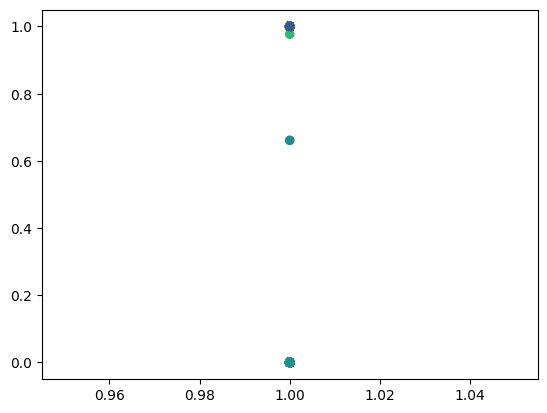

In [3]:
from sklearn.manifold import TSNE, Isomap
from umap import UMAP
from dlmp import train_model
from sklearn.datasets import make_swiss_roll
import numpy as np
from oos_isomap import *
from sklearn.preprocessing import  StandardScaler
import time


X, y = make_swiss_roll(n_samples=2000, noise=0.2, hole=True)

X = StandardScaler().fit_transform(X)

# oosmap = oos_Isomap(n_neighbors=15)

# start_t = time.perf_counter()
# oosmap.fit(X)
# print(f"fit cost: {time.perf_counter() - start_t}")

# start_t = time.perf_counter()
# X_2d = oosmap.transform_oos(X)
# print(f"embedding cost: {time.perf_counter() - start_t}")

# tsne = TSNE(perplexity=15)
# X_2d = tsne.fit_transform(X)

umap = UMAP(n_neighbors=5)
X_2d = umap.fit_transform(X)

m, _ = train_model(X, X_2d, epochs=100)
print('fit done')
X_2d = m.predict(X, verbose=True)

print(X_2d)

import matplotlib.pyplot as plt
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)
plt.show()


In [56]:
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_swiss_roll
from scipy.spatial.distance import pdist, cdist
from tqdm import tqdm
import numpy as np

k = 15
n_samples = 2000

X, y = make_swiss_roll(n_samples=n_samples, noise=0.1, hole=False)

# 1. sampling
X_train, X_test = train_test_split(X, test_size=0.3)

# 2. fit
y_train = MDS().fit_transform(X_train)

# 3. interpolating
print('start interpolating')
knn = NearestNeighbors(n_neighbors=k).fit(X_train)
dist, indi = knn.kneighbors(X_test)

all_X = np.concatenate((X_train, X_test))

P_knn = []
P_mean = []
for idxs in indi:
    P_knn.append(y_train[idxs])
    P_mean.append(np.mean(P_knn[-1], axis=0))

P_knn = np.array(P_knn)
P_mean = np.array(P_mean)

D_high_all = pdist(all_X, 'euclidean')
D_high_test = pdist(X_test, 'euclidean')
D_high_k = [cdist(X_train[indi[:, i]], X_test, 'euclidean').diagonal()[:,np.newaxis] for i in range(k)]

def loss_func(x_t_1):

    s = 0
    for i in range(k):
        D_high_i = D_high_k[i]
        D_low_i = cdist(P_knn[:, i], x_t_1, 'euclidean').diagonal()[:,np.newaxis]
        f = (x_t_1 - P_knn[:, i]) * (D_high_i / D_low_i)
        s += f / k

    x_t = P_mean + s

    S_t_1 = np.concatenate((y_train, x_t_1))
    S_t = np.concatenate((y_train, x_t))

    sigma_t_1 = np.sum((pdist(S_t_1, 'euclidean') - D_high_all)**2)
    sigma_t = np.sum((pdist(S_t, 'euclidean') - D_high_all)**2)

    return abs(sigma_t_1 - sigma_t), x_t

maxiter = 1000
eps = 1e-4
x_t = P_mean
loop = tqdm(range(maxiter))
for i in loop:
    res, x_t = loss_func(x_t_1=x_t)
    # loop.set_description(f'Epoch [{i+1}/{maxiter}]')
    loop.set_postfix(loss = f"{res:.6g}")
    if res < eps:
        break

X_2d = x_t


c:\Users\60946\dev_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


start interpolating


 41%|████      | 408/1000 [00:33<00:48, 12.09it/s, loss=9.6824e-05] 


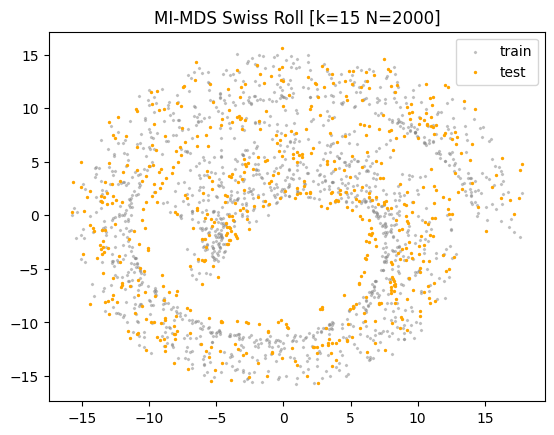

In [54]:

import matplotlib.pyplot as plt
plt.scatter(y_train[:, 0], y_train[:, 1], c='gray', alpha=0.5, marker='x',s=2, label='train')
plt.scatter(X_2d[:, 0], X_2d[:, 1], c='orange', marker='o',s=2, label='test')
plt.legend(loc='best')
plt.title(f"MI-MDS Swiss Roll [k={k} N={n_samples}]")
plt.show()


c:\Users\60946\dev_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
 31%|███       | 306/1000 [00:04<00:10, 67.41it/s, loss=0.000989869]


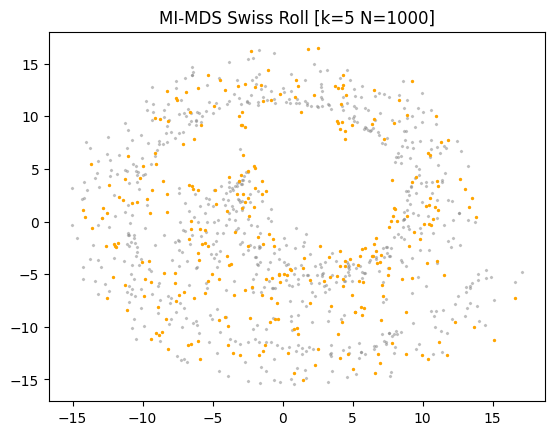

In [1]:
from mi_mds import MI_MDS
from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import train_test_split
n_samples = 1000
X, y = make_swiss_roll(n_samples=n_samples, noise=0.1, hole=False)
X_train, X_test = train_test_split(X, test_size=0.3)

k=5
mimds = MI_MDS(n_components=2, n_neighbors=k, verbose=True).fit(X=X_train)
y_train = mimds.transform()
X_2d = mimds.transform_oos(X_test, tol=0.001)

import matplotlib.pyplot as plt
plt.scatter(y_train[:, 0], y_train[:, 1], c='gray', alpha=0.5, marker='x',s=2, label='train')
plt.scatter(X_2d[:, 0], X_2d[:, 1], c='orange', marker='o',s=2, label='test')
plt.title(f"MI-MDS Swiss Roll [k={k} N={n_samples}]")
plt.show()

c:\Users\60946\dev_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS taken: 113.7912 seconds
OOS projecting taken: 6.6607 seconds


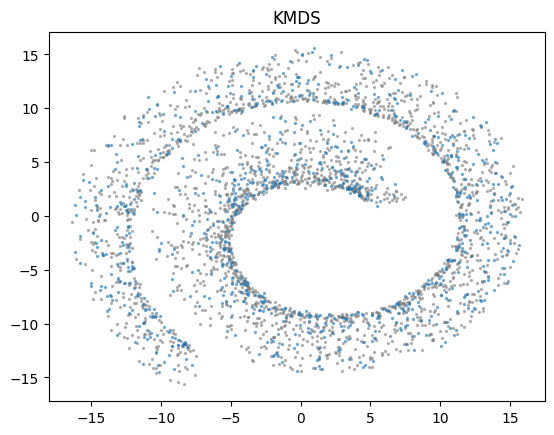

In [3]:
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
from scipy.spatial.distance import pdist, squareform
from time import perf_counter
import numpy as np

k = 10
perpl = 30
n_samples = 3000

X, y = make_swiss_roll(n_samples=n_samples, noise=0.1, hole=False)
X_train, X_test = train_test_split(X, test_size=0.3)

# y_train = TSNE(n_components=2, perplexity=perpl, n_jobs=-1, random_state=0).fit_transform(X_train)
# y_train = Isomap(n_components=2, n_neighbors=k).fit_transform(X_train)
start_time = perf_counter()
y_train = MDS(n_components=2, verbose=True).fit_transform(X_train)
print(f"MDS taken: {perf_counter() - start_time:.4f} seconds")

start_time = perf_counter()
Dtr = squareform(pdist(X_train))

a = Dtr.reshape(1, -1).copy()
a.sort()
sigma = 1 / np.sqrt(-2 * np.log(0.6)) * np.median(a[0, -10:])

K_train = np.exp(-1 * Dtr**2 / (2 * sigma**2))
K_train = K_train / np.sum(K_train, axis=1, keepdims=True)

A = np.dot(np.linalg.pinv(K_train), y_train)

Dtest = squareform(pdist(np.vstack((X_test, X_train)))) 
Dtest = Dtest[0:X_test.shape[0], -X_train.shape[0]:] # dist test to train

K_test = np.exp(-1 * Dtest**2 / (2 * sigma**2))
K_test = K_test / np.sum(K_test, axis=1, keepdims=True)
y_test = np.dot(K_test, A)
print(f"OOS projecting taken: {perf_counter() - start_time:.4f} seconds")

import matplotlib.pyplot as plt
plt.scatter(y_train[:,0], y_train[:,1], s=2, c='gray', alpha=0.5)
plt.scatter(y_test[:,0], y_test[:,1], s=2, alpha=0.5)
plt.title('KMDS')
plt.show()

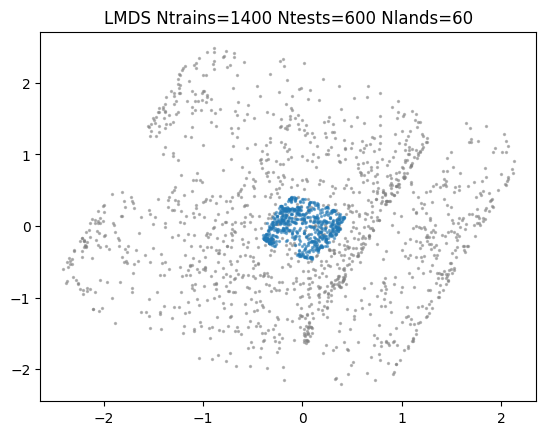

In [9]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from landmark import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
import numpy as np
import scipy
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import shortest_path, connected_components
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

def fix_connected_components(
    X,
    graph,
    n_connected_components,
    component_labels,
    mode="distance",
    metric="euclidean",
    **kwargs,
):
    if metric == "precomputed" and scipy.sparse.issparse(X):
        raise RuntimeError(
            "fix_connected_components with metric='precomputed' requires the "
            "full distance matrix in X, and does not work with a sparse "
            "neighbors graph."
        )

    for i in range(n_connected_components):
        idx_i = np.flatnonzero(component_labels == i)
        Xi = X[idx_i]
        for j in range(i):
            idx_j = np.flatnonzero(component_labels == j)
            Xj = X[idx_j]

            if metric == "precomputed":
                D = X[np.ix_(idx_i, idx_j)]
            else:
                D = pairwise_distances(Xi, Xj, metric=metric, **kwargs)

            ii, jj = np.unravel_index(D.argmin(axis=None), D.shape)
            if mode == "connectivity":
                graph[idx_i[ii], idx_j[jj]] = 1
                graph[idx_j[jj], idx_i[ii]] = 1
            elif mode == "distance":
                graph[idx_i[ii], idx_j[jj]] = D[ii, jj]
                graph[idx_j[jj], idx_i[ii]] = D[ii, jj]
            else:
                raise ValueError(
                    "Unknown mode=%r, should be one of ['connectivity', 'distance']."
                    % mode
                )

    return graph


k = 15
n_samples = 2000

X, y = make_swiss_roll(n_samples=n_samples, noise=0.01, hole=True)
# X = StandardScaler().fit_transform(X)
X_train, X_test = train_test_split(X, test_size=0.3)

# D = cdist(X_train, X_train, 'euclidean')
# D = geodesic_distance(X_train, k=k)

# y_train = MDS(D, dim=2)

# Dt = cdist(X_test, X_test, 'euclidean')
# Dt = geodesic_distance(X_test, k=k)
# lands_test = farthest_point_sample(X_test.shape[0], Dt, int(X_test.shape[0] / 10))

# Dl2 = Dt[lands_test, :]

# y_test = landmark_MDS(Dl2, lands_test, dim=2)

lmds = LandmarkMDS()
lmds.fit(X_train)
y_train = lmds.transform()
y_test = lmds.transform_oos(X_test)

# lisomap = LandmarkIsomap(n_neighbors=k)
# lisomap.fit(X_train)
# y_train = lisomap.transform()
# y_test = lisomap.transform_oos(X_test)

import matplotlib.pyplot as plt
plt.scatter(y_train[:,0], y_train[:,1], s=2, c='gray', alpha=0.5)
plt.scatter(y_test[:,0], y_test[:,1], s=2, alpha=0.5)
plt.title(f'LMDS Ntrains={X_train.shape[0]} Ntests={X_test.shape[0]} Nlands={lmds.n_landmark()}')
plt.show()

c:\Users\60946\dev_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\60946\dev_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


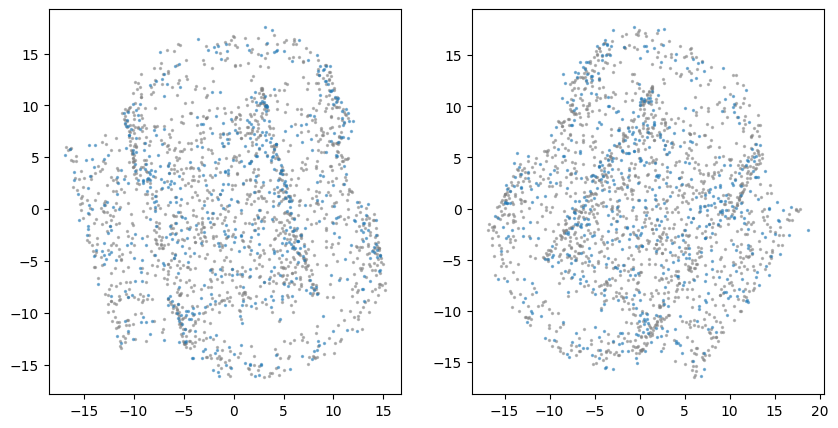

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
from kernel_base import KernalIsomap, KernelMDS, KernelTSNE
from mi_mds import  MI_MDS

n_samples = 2000

X, y = make_swiss_roll(n_samples=n_samples, noise=0.01, hole=True)
# X = StandardScaler().fit_transform(X)
X_train, X_test = train_test_split(X, test_size=0.3)

kernelBase = KernelMDS().fit(X_train)
# kernelBase = KernalIsomap().fit(X_train)
# kernelBase = KernelTSNE().fit(X_train)

y_train = kernelBase.transform()
y_test = kernelBase.transform_oos(X_test)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.scatter(y_train[:,0], y_train[:,1], s=2, c='gray', alpha=0.5)
ax.scatter(y_test[:,0], y_test[:,1], s=2, alpha=0.5)
# ax.title(f'{kernelBase.__class__.__name__} Ntrains={X_train.shape[0]} Ntests={X_test.shape[0]}')

kernelBase = MI_MDS().fit(X_train)
y_train = kernelBase.transform()
y_test = kernelBase.transform_oos(X_test)

ax1 = fig.add_subplot(122)
ax1.scatter(y_train[:,0], y_train[:,1], s=2, c='gray', alpha=0.5)
ax1.scatter(y_test[:,0], y_test[:,1], s=2, alpha=0.5)
# ax1.title(f'{kernelBase.__class__.__name__} Ntrains={X_train.shape[0]} Ntests={X_test.shape[0]}')

plt.show()


ValueError: Negative values in data passed to precomputed distance matrix.

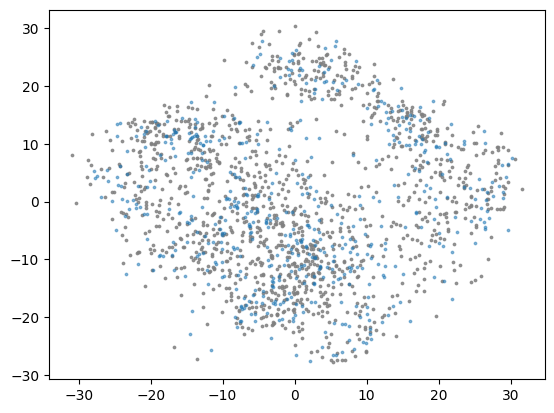

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.neighbors import NearestNeighbors

X, label = load_digits(return_X_y=True)
X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.3, random_state=40)

pca = PCA(n_components=2, random_state=100).fit(X_train)
proj_train = pca.transform(X_train)
proj_test = pca.transform(X_test)

# umap = UMAP(n_components=2, random_state=100)
# proj_train = umap.fit_transform(X_train)
# proj_test = umap.fit_transform(X_test)

k=2
import matplotlib.pyplot as plt
plt.scatter(proj_train[:,0], proj_train[:,1], s=3, c='gray', alpha=0.8)
plt.scatter(proj_test[:,0], proj_test[:,1], s=3, alpha=0.5)

knn = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(proj_train)
distances, indices = knn.kneighbors(proj_train)

y_true = label_train
y_pred = label_train[indices[:, 1]]
acc = accuracy_score(y_true, y_pred)
print(f'Train Accuracy: {acc:.2f}')


knn = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(proj_test)
distances, indices = knn.kneighbors(proj_test)

y_true = label_test
y_pred = label_test[indices[:, 1]]
acc = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {acc:.2f}')


